&nbsp;

# 17 - Mémoire et fermeture markovienne de l'état réduit

---

&nbsp;

## 1. Introduction et objectif

Toujours dans l'optique de nous aiguiller sur la classe de modèles SciML "admissibles", nous pouvons chercher une dernière distinction.

&nbsp;

> #### L'état réduit est-il suffisant pour décrire la dynamique ?

C'est une question fondamentale sur laquelle nous n'avons pas encore tranchée (et sur laquelle on ne peut pas pour le moment).

Répondre à cette question revient à s'interroger sur ce qu'on appelle la fermeture dynamique en étude des systèmes. Étudier la fermeture consiste à chercher des dépendances ou des excitations du système que l'on souhaite approximer. L'hypothèse fondamentale de notre état est qu'il est parfaitement "fermée", soit :

$$
\dot{x}(t) = f(x(t))
$$

Si l'hypothèse d'un défaut de fermeture est admise, donc que le système est présumé dépendant/exciter par quelconques facteurs, alors notre état peut ressembler à :

$$
\text{(1)} \space \dot{x}(t) = f(x(t)) + g(t)
$$

ou :

$$
\text{(2)} \space \dot{x}(t) = f(x(t), x(t-\tau))
$$

ou encore :

$$
\text{(3)} \space \dot{x}(t) = f(x(t), u(t))
$$

De ces possiblités découlent alors une autre interrogation.

&nbsp;

> #### La problème de fermeture est-il de nature temporelle ou structurelle ?

Si le défaut est de nature temporelle alors on émet l'hypothèse que l'état est incomplet dans le temps. Et s'il est incomplet dans le temps, cela ne peut dire qu'une chose que le passé transporte de l'information dynamique, on parle dans ce cas là de *non-markovianité* en témoignage aux processus markoviens décrivant les systèmes ne dépendant pas des valeurs passées pour déterminer les futures. Cela correspond à notre cas $\text{(1)}$ et c'est l'hypothèse que nous allons testé dans ce notebook.

Si ce notebook indique un défaut de fermeture mais invalide l'hypothèse de *non-markovianité*, correspondant à un défaut de fermeture temporel, cela signifie probablement qu'un défaut de fermeture structurel est en cause, les équations $\text{(2)}$ et $\text{(3)}$ dans notre cas. Dans ce scénario nous étudierons cette nouvelle hypothèse dans un nouveau notebook dédié.

&nbsp;

---

&nbsp;

## 2. Autocorrélation des dérivées

L'autocorrélation de $\dot{x}(t)$ est : 

$$
\mathcal{C}_{\dot{x}}(\tau) = \mathbb{E}[\dot{x}(t)\dot{x}(t +\tau)]
$$

C'est la mesure qui décrit l'amplitude de la ressemblance de la dérivée à elle-même parès un décalage temporel $\tau$. Le calcul de cette indicateur rentre tout à fait dans le registre de la réponse que l'on cherche à apporter car on veut tester l'hypothèse de Markovianité. Calculons et discutons des résultats possibles.



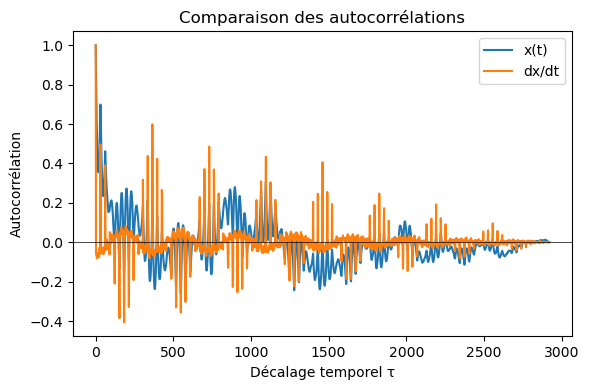

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Basic initialization from the latest processed data
data = np.load("data/processed/sstReducedStateCOPERNICUS20102019Prepared.npz")

PCs = data["PCsTrain"]
t   = data["tTrain"]

dt = float(np.mean(np.diff(t))) # We set the time step (for the derivative scale)

x0 = PCs[:, 0]  # initial condition for the first PC

dxDt = np.gradient(x0, dt)  # dérivée temporelle de la première PC

# We remove the mean to focus on fluctuations
dx = dxDt - np.mean(dxDt)

# We compute the autocorrelation function
acf = np.correlate(dx, dx, mode="full")
acf = acf[acf.size // 2:]  # keep only non-negative lags
acf /= acf[0]              # normalize

lags = np.arange(len(acf)) * dt # convert to time lags

x0Centered = x0 - np.mean(x0)  # remove mean from the original signal

acfX = np.correlate(x0, x0, mode="full")
acfX = acfX[acfX.size // 2:]
acfX /= acfX[0]

plt.figure(figsize=(6, 4))
plt.plot(lags, acfX, label="x(t)")
plt.plot(lags, acf, label="dx/dt")
plt.axhline(0, color="k", linewidth=0.5)
plt.xlabel("Décalage temporel τ")
plt.ylabel("Autocorrélation")
plt.legend()
plt.title("Comparaison des autocorrélations")
plt.tight_layout()
plt.show()



Pour $\dot{x}$, on observe :
- un pic trivial à $\tau = 0$
- une décroissance globale et progressive
- des oscillations persistantes avec alternance de signes
- une amplitude qui diminue lentement

Ce que ça signifie pour nous c'est qu'il existe bien une structure temporelle qui se caractérise par une autocorrélation oscillante (présence d'une composante quasi-oscillatorie donc), ce qui est cohérent voire typique des systèmes dissipatifs. L'information passée finie par être oubliée. Attention cela n'implique automatiquement une mémoire non-markovienne.

La comparaison entre les autocorrélations est l'indice important ici.

Pour faire simple, l'hypothèse d'un système markovien présume qu'il existe une fonction $\mathcal{f}$ telle que :

$$
\dot{x}(t) = f(x(t))
$$

Cela implique donc que la seule variable porteuse du passé est $x(t)$. $\dot{x}(t)$ n'a donc pas de raison d'être corrélé longtemps, celle-ci ne reflète que la persistance de l'état.

Dans un système réel (comme le nôtre), l'autocorrélation ne tombe jamais instantanément à zéro, on ne parle donc pas de *markovianité* mais de *quasi-markovianité* où :

$$
\dot{x}(t) \approx f(x(t))
$$

Dans notre cas, le passé est relativement rapidement oublié. On peut établir cela en comparant le temps de décorrélation de la dérivée et le temps de caractéristique de l'état comme suit :

$$
\tau_\text{corr}(\dot{x}) \ll \tau_\text{dyn}(x)
$$

Le système n'est pas strictement markovien et l'hypothèse n'est pas rejettée, on parle ainsi de *quasi-markovianité* (uniquement dans le cas d'un défaut de fermeture temporelle). 